In [1]:
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold

from keras.preprocessing.image import ImageDataGenerator
import os

from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import pickle

In [2]:
#importing dataset
data = tf.keras.utils.image_dataset_from_directory(
    "main",
    labels='inferred',label_mode='categorical',image_size=(256,256),
    batch_size=1
)

Found 64 files belonging to 2 classes.


In [3]:
#creating the augmented dataset
aug_ds = data.map(
  lambda x, y: (tf.image.flip_left_right(x), y))


In [4]:
class_names = data.class_names
class_names #the image_data_from_directory function choses the folder name as classes

['non-stroke', 'stroke']

In [5]:
dataX = []
dataY = []
for i in data.as_numpy_iterator():
  dataX.append(i[0])
  dataY.append(i[1])


for i in aug_ds.as_numpy_iterator():
  if i[1][0][1] == 1.: 
    dataX.append(i[0])
    dataY.append(i[1])
dataX = np.array(dataX)
dataY = np.array(dataY)
dataX = np.reshape(dataX,(dataX.shape[0],256,256,3))
dataY = np.reshape(dataY,(dataY.shape[0],2))
dataX.shape, dataY.shape #87 images in total along with labels


((87, 256, 256, 3), (87, 2))

In [6]:
def define_model():
  
  model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255), #normalize the data
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(192, activation='relu'),
  tf.keras.layers.Dense(2,activation='sigmoid')
  ])

  opt = tf.keras.optimizers.SGD(learning_rate=0.01)
  model.compile(optimizer=opt, 
                loss=tf.keras.losses.BinaryCrossentropy(), 
                metrics=['accuracy',
                tf.keras.metrics.AUC(name='AUC'),
                tf.keras.metrics.Precision(name='Precision'),
                tf.keras.metrics.Recall(name="Recall")])
  return model


In [7]:
def train_and_evaluate_model(dataX, dataY, n_folds=3):
  scores, histories = list(), list()
  models = []
  # prepare cross validation
  kfold = KFold(n_folds, shuffle=True, random_state=1)
  # enumerate splits
  for train_ix, test_ix in kfold.split(dataX):
    # define model
    model = define_model()
    
    # select rows for train and test
    trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
    # fit model
    history = model.fit(trainX, trainY, epochs=10, batch_size=1, validation_data=(testX, testY), verbose=1)
    # evaluate model
    _, acc, _ , _, _= model.evaluate(testX, testY, verbose=1)
    print('> %.3f' % (acc * 100.0))
    # stores scores
    scores.append(acc)
    models.append(model)
    histories.append(history)
  model.summary()

  return scores, histories, models

In [8]:
def summarize_diagnostics(histories):
  plt.figure(figsize=(10,10))
  colors = ['r','y','blue']
  for i in range(len(histories)):
    # plot loss
    
    pyplot.subplot(2, 1, 1)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(histories[i].history['loss'], color=colors[i], label='train')
    pyplot.plot(histories[i].history['val_loss'], color=colors[i], label='test',ls='dashed')
    # plot accuracy
    pyplot.subplot(2, 1, 2)
    pyplot.title('Classification Accuracy')
    pyplot.plot(histories[i].history['accuracy'], color='blue', label='train')
    pyplot.plot(histories[i].history['val_accuracy'], color='orange', label='test')
  
  pyplot.show()


# summarize model performance
def summarize_performance(scores):
  # print summary
  print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
  # box and whisker plots of results
  pyplot.boxplot(scores)
  pyplot.show()
  

In [9]:
scores, histories, models = train_and_evaluate_model(dataX,dataY)

Epoch 1/10
58/58 [==============================] - 44s 179ms/step - loss: 0.7237 - accuracy: 0.5345 - AUC: 0.4917 - Precision: 0.5357 - Recall: 0.5172 - val_loss: 0.6687 - val_accuracy: 0.6207 - val_AUC: 0.7741 - val_Precision: 0.6333 - val_Recall: 0.6552
Epoch 2/10
58/58 [==============================] - 8s 144ms/step - loss: 0.6628 - accuracy: 0.6207 - AUC: 0.6587 - Precision: 0.6140 - Recall: 0.6034 - val_loss: 0.7316 - val_accuracy: 0.4483 - val_AUC: 0.6254 - val_Precision: 0.4483 - val_Recall: 0.4483
Epoch 3/10
58/58 [==============================] - 8s 145ms/step - loss: 0.5794 - accuracy: 0.8276 - AUC: 0.7947 - Precision: 0.8276 - Recall: 0.8276 - val_loss: 0.7720 - val_accuracy: 0.4828 - val_AUC: 0.5922 - val_Precision: 0.4828 - val_Recall: 0.4828
Epoch 4/10
58/58 [==============================] - 8s 146ms/step - loss: 0.5937 - accuracy: 0.7414 - AUC: 0.7760 - Precision: 0.7368 - Recall: 0.7241 - val_loss: 0.6790 - val_accuracy: 0.5517 - val_AUC: 0.6516 - val_Precision: 0.5

In [10]:
#metrics for the folds
for i in range(len(histories)):
    p = np.mean(histories[i].history['val_Precision'])
    r = np.mean(histories[i].history['val_Recall'])
    auc = np.mean(histories[i].history['val_AUC'])
    acc = np.mean(histories[i].history['val_accuracy'])
    f1 = (2*(p*r))/(p+r)
    print("Fold "+ str(i+1))
    print(f'Accuracy: {acc*100:.3f}')
    print(f'f1 score: {f1:.3f}')
    print(f'Precision: {p:.3f}')
    print(f'Recall: {r:.3f}')
    print(f'AUC: {auc:.3f}')

Fold 1
Accuracy: 59.310
f1 score: 0.599
Precision: 0.597
Recall: 0.600
AUC: 0.678
Fold 2
Accuracy: 70.345
f1 score: 0.700
Precision: 0.690
Recall: 0.710
AUC: 0.782
Fold 3
Accuracy: 75.172
f1 score: 0.742
Precision: 0.746
Recall: 0.738
AUC: 0.820


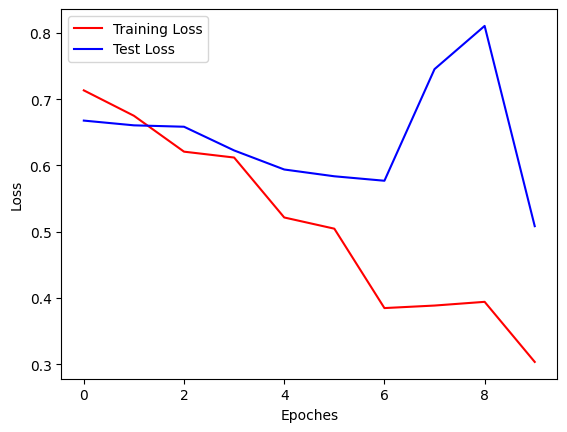

In [11]:
avg_loss = np.add(np.add(histories[0].history['loss'], histories[2].history['loss']), histories[1].history['loss'])/3
avg_val_loss = np.add(np.add(histories[0].history['val_loss'], histories[2].history['val_loss']), histories[1].history['val_loss'])/3
#plot of train vs test loss
plt.plot(avg_loss[:],c='r')
plt.plot(avg_val_loss[:],c='b')
plt.xlabel("Epoches")
plt.ylabel("Loss")
plt.legend(["Training Loss","Test Loss"])
plt.show()

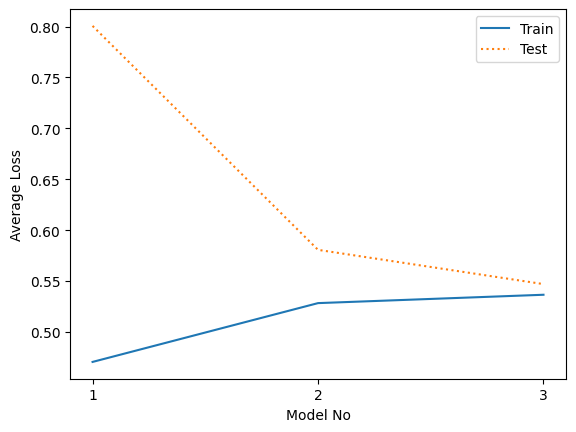

In [12]:
avg_loss = []
avg_val_loss = []
#loss of the different folds
for h in histories:
  avg_loss.append(np.average(h.history['loss']))
  avg_val_loss.append(np.average(h.history['val_loss']))
plt.plot(avg_loss)
plt.plot(avg_val_loss,ls='dotted')
default = range(len(avg_loss))
plt.xlabel('Model No')
plt.xticks(default,[1,2,3])                            
plt.ylabel("Average Loss")
plt.legend(["Train","Test"])
plt.show()

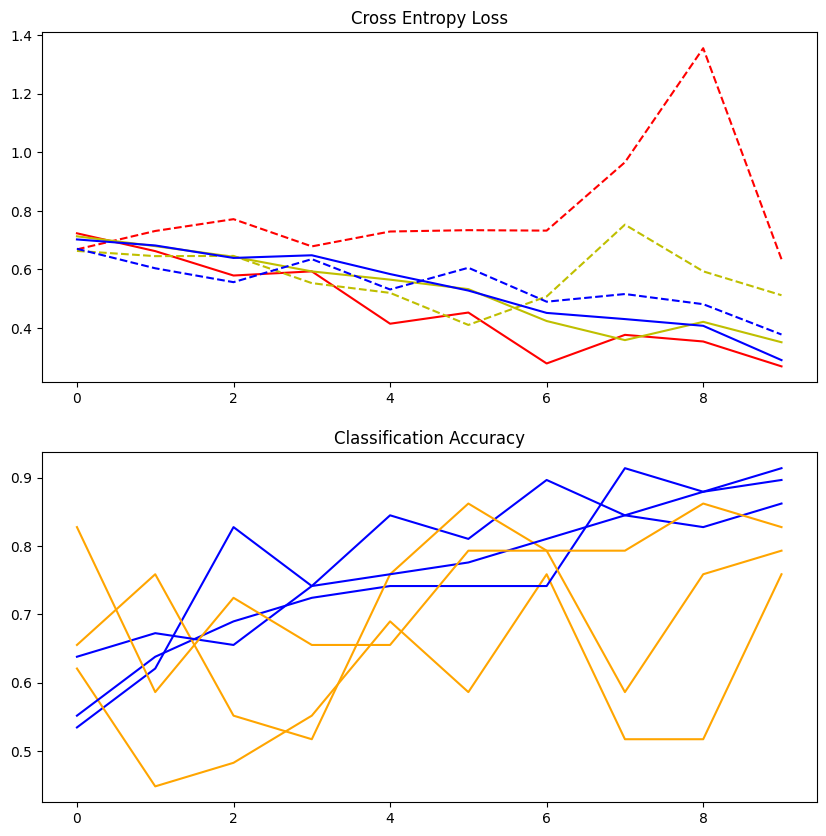

Accuracy: mean=79.310 std=2.816, n=3


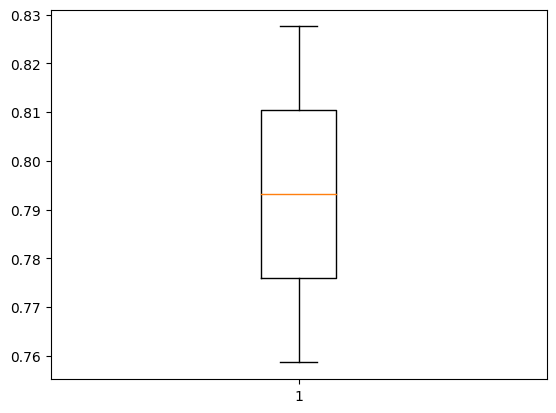

In [13]:
summarize_diagnostics(histories)
summarize_performance(scores)